In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

## Data Pre-processing

In [2]:
fraudTrain = pd.read_csv('Train_data/fraudTrain.csv')
fraudTest = pd.read_csv('Train_data/fraudTest.csv')

In [3]:
fraudTrain.columns

Index(['Unnamed: 0', 'trans_date_trans_time', 'cc_num', 'merchant', 'category',
       'amt', 'first', 'last', 'gender', 'street', 'city', 'state', 'zip',
       'lat', 'long', 'city_pop', 'job', 'dob', 'trans_num', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud'],
      dtype='object')

In [4]:
fraudTrain.head()

,Unnamed: 0,trans_date_trans_time,cc_num,merchant,category,amt,first,last,gender,street,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
0,0,2019-01-01 00:00:18,2703186189652095,"fraud_Rippin, Kub and Mann",misc_net,4.97,Jennifer,Banks,F,561 Perry Cove,...,36.0788,-81.1781,3495,"Psychologist, counselling",1988-03-09,0b242abb623afc578575680df30655b9,1325376018,36.011293,-82.048315,0
1,1,2019-01-01 00:00:44,630423337322,"fraud_Heller, Gutmann and Zieme",grocery_pos,107.23,Stephanie,Gill,F,43039 Riley Greens Suite 393,...,48.8878,-118.2105,149,Special educational needs teacher,1978-06-21,1f76529f8574734946361c461b024d99,1325376044,49.159047,-118.186462,0
2,2,2019-01-01 00:00:51,38859492057661,fraud_Lind-Buckridge,entertainment,220.11,Edward,Sanchez,M,594 White Dale Suite 530,...,42.1808,-112.2620,4154,Nature conservation officer,1962-01-19,a1a22d70485983eac12b5b88dad1cf95,1325376051,43.150704,-112.154481,0
3,3,2019-01-01 00:01:16,3534093764340240,"fraud_Kutch, Hermiston and Farrell",gas_transport,45.00,Jeremy,White,M,9443 Cynthia Court Apt. 038,...,46.2306,-112.1138,1939,Patent attorney,1967-01-12,6b849c168bdad6f867558c3793159a81,1325376076,47.034331,-112.561071,0
4,4,2019-01-01 00:03:06,375534208663984,fraud_Keeling-Crist,misc_pos,41.96,Tyler,Garcia,M,408 Bradley Rest,...,38.4207,-79.4629,99,Dance movement psychotherapist,1986-03-28,a41d7549acf90789359a9aa5346dcb46,1325376186,38.674999,-78.632459,0


In [5]:
# --- Preprocessing ---

# Drop 'Unnamed: 0' column
fraudTrain = fraudTrain.drop('Unnamed: 0', axis=1)
fraudTest = fraudTest.drop('Unnamed: 0', axis=1)

# Convert 'trans_date_trans_time' to datetime objects and feature engineering
fraudTrain['trans_date_trans_time'] = pd.to_datetime(fraudTrain['trans_date_trans_time'])
fraudTest['trans_date_trans_time'] = pd.to_datetime(fraudTest['trans_date_trans_time'])

fraudTrain['transaction_hour'] = fraudTrain['trans_date_trans_time'].dt.hour
fraudTrain['transaction_day_of_week'] = fraudTrain['trans_date_trans_time'].dt.dayofweek
fraudTrain['transaction_month'] = fraudTrain['trans_date_trans_time'].dt.month
fraudTrain['transaction_year'] = fraudTrain['trans_date_trans_time'].dt.year

fraudTest['transaction_hour'] = fraudTest['trans_date_trans_time'].dt.hour
fraudTest['transaction_day_of_week'] = fraudTest['trans_date_trans_time'].dt.dayofweek
fraudTest['transaction_month'] = fraudTest['trans_date_trans_time'].dt.month
fraudTest['transaction_year'] = fraudTest['trans_date_trans_time'].dt.year

In [6]:
# Make sure both columns are datetime
fraudTrain['dob'] = pd.to_datetime(fraudTrain['dob'])
fraudTest['dob'] = pd.to_datetime(fraudTest['dob'])

fraudTrain['trans_date_trans_time'] = pd.to_datetime(fraudTrain['trans_date_trans_time'])
fraudTest['trans_date_trans_time'] = pd.to_datetime(fraudTest['trans_date_trans_time'])

# Age calculation function
def calculate_age(row):
    birth_date = row['dob']
    transaction_date = row['trans_date_trans_time']
    age = transaction_date.year - birth_date.year - (
        (transaction_date.month, transaction_date.day) < (birth_date.month, birth_date.day)
    )
    return age

# Apply the function
fraudTrain['age'] = fraudTrain.apply(calculate_age, axis=1)
fraudTest['age'] = fraudTest.apply(calculate_age, axis=1)

# Drop dob column
fraudTrain = fraudTrain.drop('dob', axis=1)
fraudTest = fraudTest.drop('dob', axis=1)

In [7]:
# Drop original timestamp
fraudTrain = fraudTrain.drop('trans_date_trans_time', axis=1)
fraudTest = fraudTest.drop('trans_date_trans_time', axis=1)

# Drop high cardinality identifiers (for this initial run)
fraudTrain = fraudTrain.drop(['cc_num', 'trans_num'], axis=1, errors='ignore')
fraudTest = fraudTest.drop(['cc_num', 'trans_num'], axis=1, errors='ignore')

In [8]:
print("Columns in fraudTrain before one-hot encoding:", fraudTrain.columns)

Columns in fraudTrain before one-hot encoding: Index(['merchant', 'category', 'amt', 'first', 'last', 'gender', 'street',
       'city', 'state', 'zip', 'lat', 'long', 'city_pop', 'job', 'unix_time',
       'merch_lat', 'merch_long', 'is_fraud', 'transaction_hour',
       'transaction_day_of_week', 'transaction_month', 'transaction_year',
       'age'],
      dtype='object')


## One-Hot Encoding

In [9]:
# Drop 'unix_time'
fraudTrain = fraudTrain.drop('unix_time', axis=1, errors='ignore')
fraudTest = fraudTest.drop('unix_time', axis=1, errors='ignore')

# One-hot encode categorical columns
categorical_cols_to_one_hot = ['merchant', 'first', 'last', 'gender', 'street', 'city', 'state', 'job']

fraudTrain = pd.get_dummies(fraudTrain, columns=categorical_cols_to_one_hot, prefix=categorical_cols_to_one_hot, dummy_na=False)
fraudTest = pd.get_dummies(fraudTest, columns=categorical_cols_to_one_hot, prefix=categorical_cols_to_one_hot, dummy_na=False)


In [10]:
# Separate features and target variable AFTER one-hot encoding
X_train = fraudTrain.drop('is_fraud', axis=1, errors='ignore')
y_train = fraudTrain['is_fraud']
X_test = fraudTest.drop('is_fraud', axis=1, errors='ignore')
y_test = fraudTest['is_fraud']

In [11]:
# Scale numerical features
numerical_cols = ['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age',
                  'transaction_hour', 'transaction_day_of_week', 'transaction_month']
scaler = StandardScaler()

# Ensure that the columns exist in both DataFrames before scaling
numerical_cols_train = [col for col in numerical_cols if col in X_train.columns]
numerical_cols_test = [col for col in numerical_cols if col in X_test.columns]

X_train[numerical_cols_train] = scaler.fit_transform(X_train[numerical_cols_train])
X_test[numerical_cols_test] = scaler.transform(X_test[numerical_cols_test])

## Feature Selection

In [12]:
from imblearn.over_sampling import SMOTE
import numpy as np

# Feature Selection
# You should select the features that you believe are most relevant for fraud detection.
# This is just an example, you might need to adjust the feature names based on your analysis.
selected_features = ['amt', 'zip', 'lat', 'long', 'city_pop', 'merch_lat', 'merch_long', 'age',
                     'transaction_hour', 'transaction_day_of_week', 'transaction_month',
                     'merchant_freq', 'job_freq'] + [col for col in X_train.columns if col.startswith('category_')]

# Make sure all selected features are actually present in X_train
selected_features = [feature for feature in selected_features if feature in X_train.columns]

X_train_selected = X_train[selected_features]

# Ensure y_train is a 1D array
y_train = np.array(y_train).ravel()

# --- Handle class imbalance with SMOTE on the selected features ---
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)

print("Shape of original training data (selected features):", X_train_selected.shape)
print("Shape of resampled training data:", X_train_resampled.shape)

Shape of original training data (selected features): (1296675, 11)
Shape of resampled training data: (2578338, 11)


In [13]:
selected_features_test = [feature for feature in selected_features if feature in X_test.columns]
X_test_selected = X_test[selected_features_test]

print("Shape of original test data (selected features):", X_test_selected.shape)

Shape of original test data (selected features): (555719, 11)


In [21]:
# y_train_resampled_fraud = y_train_resampled[y_train_resampled['is_fraud'] == 1]
c = 0
for i in y_train_resampled:
    if i == 0:
        c+=1
        # print(y_train_resampled)

print(c)

1289169


## Correlation Matrix

From the matrix we can see, almost every element is independent to each other, except some terms related to demographic notations(zipcode, latitude, longitudes) and its good that model identified the relation correctly(Resembling Data preprocessing executed correctly)

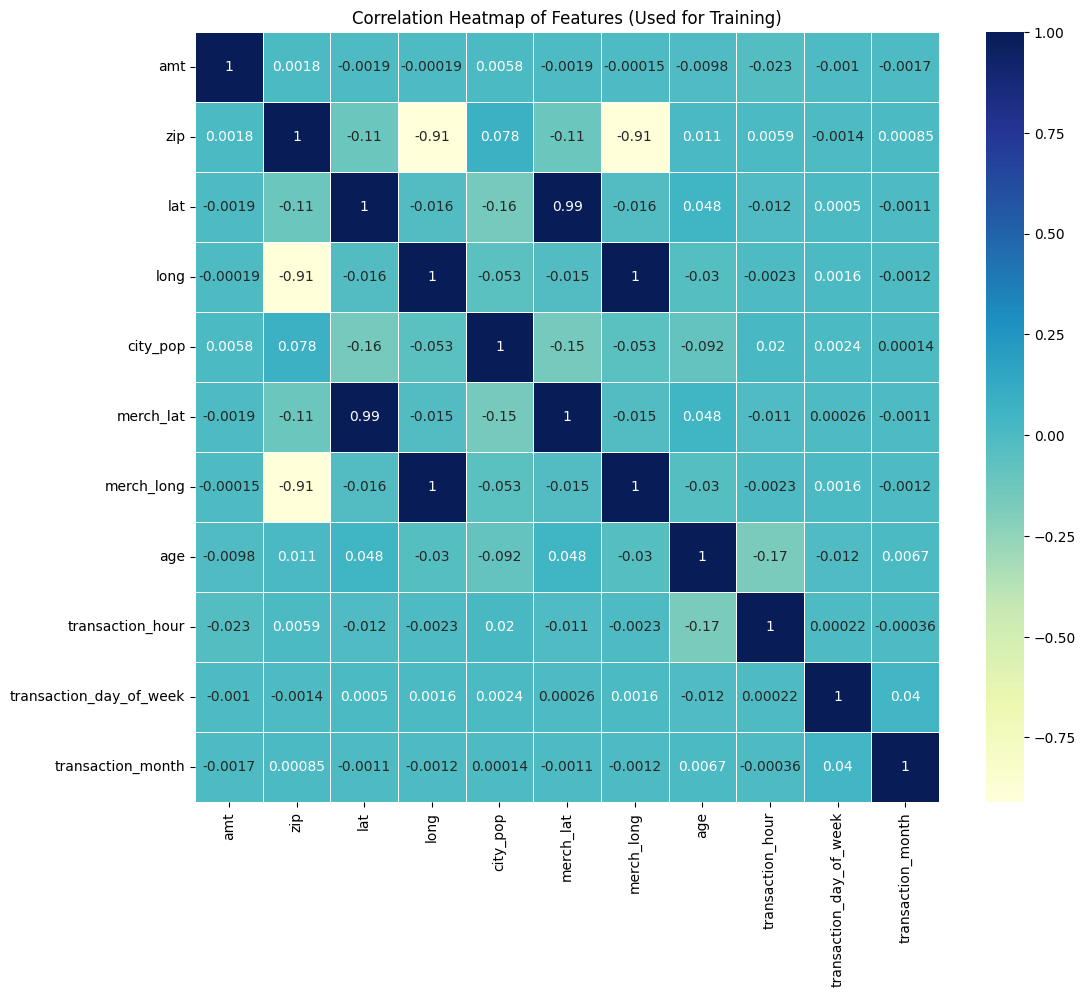

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the correlation matrix on X_train_selected
correlation_matrix_features = X_train_selected.corr()

# Create a heatmap of the feature correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_features,linewidths=0.5, annot=True, cmap='YlGnBu')
plt.title('Correlation Heatmap of Features (Used for Training)')
plt.show()

In [15]:
# --- Logistic Regression ---
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train_resampled, y_train_resampled)
lr_predictions = lr_model.predict(X_test_selected)
print("\n--- Logistic Regression ---")
print(classification_report(y_test, lr_predictions))


--- Logistic Regression ---
              precision    recall  f1-score   support

           0       1.00      0.97      0.98    553574
           1       0.08      0.74      0.14      2145

    accuracy                           0.97    555719
   macro avg       0.54      0.85      0.56    555719
weighted avg       1.00      0.97      0.98    555719



In [16]:
# --- XGBoost ---
xgb_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train_resampled, y_train_resampled)
xgb_predictions = xgb_model.predict(X_test_selected)
print("\n--- XGBoost ---")
print(classification_report(y_test, xgb_predictions))

c:\Users\B_Jayanth\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [23:40:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



--- XGBoost ---
              precision    recall  f1-score   support

           0       1.00      0.99      1.00    553574
           1       0.33      0.66      0.44      2145

    accuracy                           0.99    555719
   macro avg       0.66      0.83      0.72    555719
weighted avg       1.00      0.99      0.99    555719



In [17]:
# --- Random Forest ---
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)
rf_predictions = rf_model.predict(X_test_selected)
print("\n--- Random Forest ---")
print(classification_report(y_test, rf_predictions))


--- Random Forest ---
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    553574
           1       0.59      0.55      0.57      2145

    accuracy                           1.00    555719
   macro avg       0.79      0.77      0.78    555719
weighted avg       1.00      1.00      1.00    555719



## ROC Curves

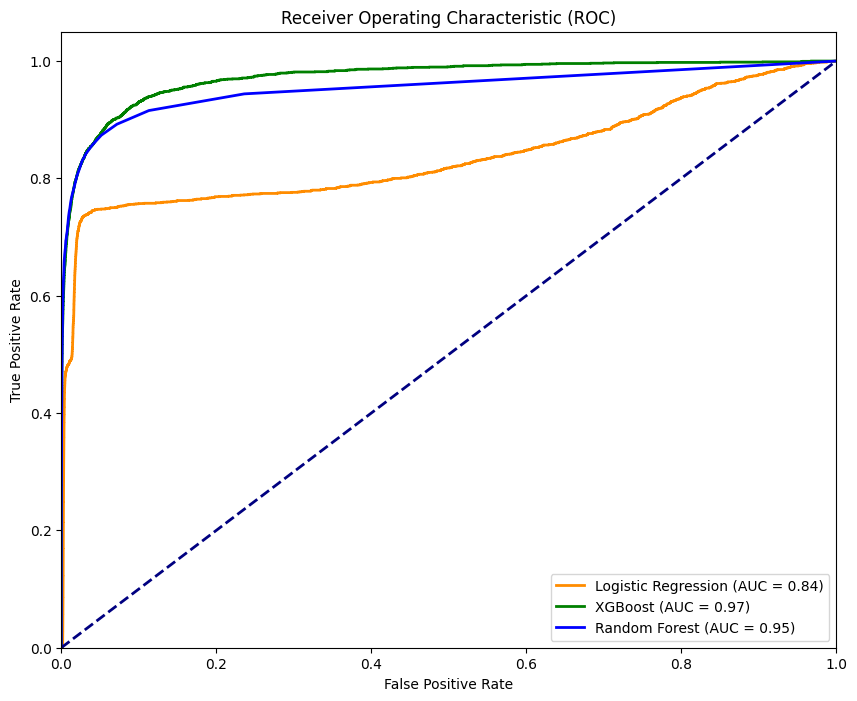

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- ROC Curve ---
plt.figure(figsize=(10, 8))

# Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_model.predict_proba(X_test_selected)[:, 1])
roc_auc_lr = auc(fpr_lr, tpr_lr)
plt.plot(fpr_lr, tpr_lr, color='darkorange', lw=2, label=f'Logistic Regression (AUC = {roc_auc_lr:.2f})')

# XGBoost
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, xgb_model.predict_proba(X_test_selected)[:, 1])
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')

# Random Forest
fpr_rf, tpr_rf, _ = roc_curve(y_test, rf_model.predict_proba(X_test_selected)[:, 1])
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='blue', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## Confusion Matrix
Actual vs Predicted (outputs = ['Not Fraud', 'Fraud'])

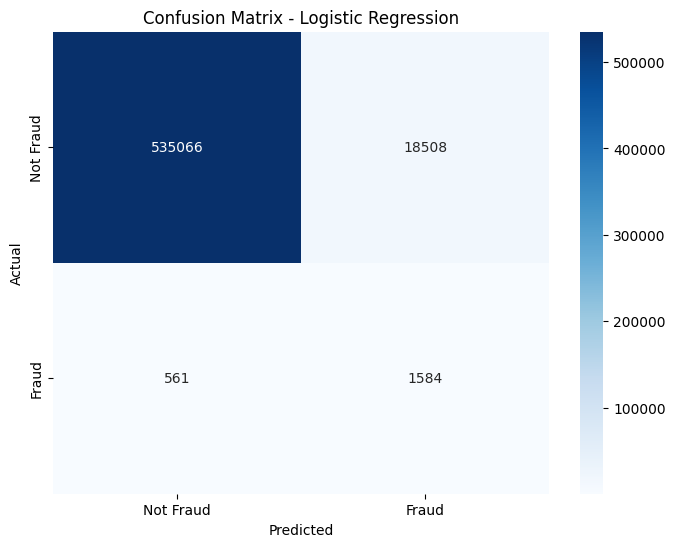

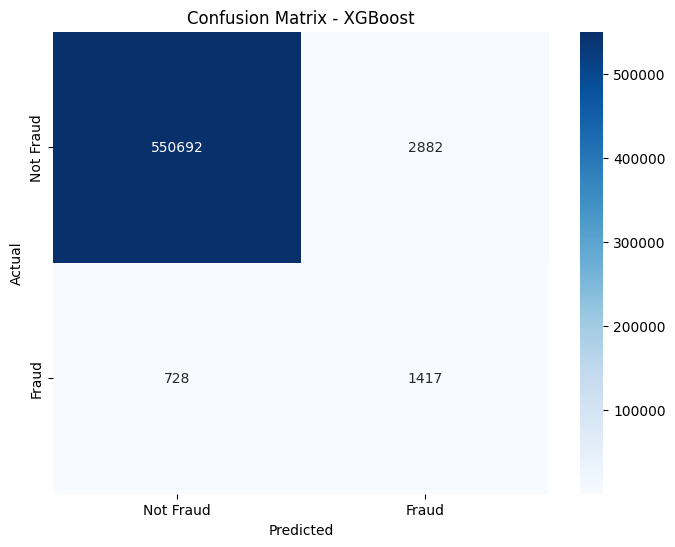

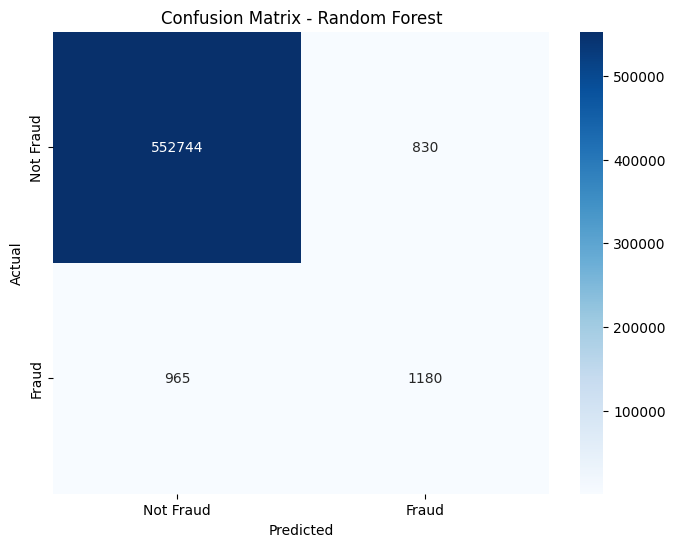

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# --- Function to plot confusion matrix ---
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Not Fraud', 'Fraud'],
                yticklabels=['Not Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# --- Plotting confusion matrix for Logistic Regression ---
plot_confusion_matrix(y_test, lr_predictions, 'Logistic Regression')

# --- Plotting confusion matrix for XGBoost ---
plot_confusion_matrix(y_test, xgb_predictions, 'XGBoost')

# --- Plotting confusion matrix for Random Forest ---
plot_confusion_matrix(y_test, rf_predictions, 'Random Forest')

In [20]:
from sklearn.metrics import accuracy_score

# --- Calculate and print accuracies ---

# Logistic Regression Accuracy
lr_accuracy = accuracy_score(y_test, lr_predictions)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")

# XGBoost Accuracy
xgb_accuracy = accuracy_score(y_test, xgb_predictions)
print(f"XGBoost Accuracy: {xgb_accuracy:.4f}")

# Random Forest Accuracy
rf_accuracy = accuracy_score(y_test, rf_predictions)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Logistic Regression Accuracy: 0.9657
XGBoost Accuracy: 0.9935
Random Forest Accuracy: 0.9968


## HyperParameter Tuning

Hyperparameter tuning is used to update the weights of the model for increasing the precision by adding learning rates or optimization for updating weights.

In [21]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score # You might want to optimize for recall or precision

# Define the scoring metric (e.g., F1-score for the positive class)
scoring = make_scorer(f1_score, pos_label=1)

For Logistic Regression

In [22]:
# Define the hyperparameter grid for Logistic Regression
param_grid_lr = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear']
}

# Perform GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(LogisticRegression(random_state=42), param_grid_lr, scoring=scoring, cv=3)
grid_search_lr.fit(X_train_resampled, y_train_resampled)
print("Best hyperparameters for Logistic Regression:", grid_search_lr.best_params_)

Best hyperparameters for Logistic Regression: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}


For XGBoost

In [ ]:
# Define the hyperparameter grid for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'max_depth': [3, 5, 7, 9],
    'n_estimators': [100, 200, 300]
}

# Perform RandomizedSearchCV for XGBoost (more efficient for larger spaces)
random_search_xgb = RandomizedSearchCV(XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'), param_grid_xgb, scoring=scoring, cv=3, n_iter=10)
random_search_xgb.fit(X_train_resampled, y_train_resampled)
print("Best hyperparameters for XGBoost:", random_search_xgb.best_params_)

For Random Forest

In [ ]:
# Define the hyperparameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Perform RandomizedSearchCV for Random Forest
random_search_rf = RandomizedSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, scoring=scoring, cv=3, n_iter=10)
random_search_rf.fit(X_train_resampled, y_train_resampled)
print("Best hyperparameters for Random Forest:", random_search_rf.best_params_)

In [ ]:
# You can then use the best estimators to make predictions
best_lr_model = grid_search_lr.best_estimator_
best_xgb_model = random_search_xgb.best_estimator_
best_rf_model = random_search_rf.best_estimator_

## Final Evaluation

In [25]:
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# --- Evaluate the best Random Forest model ---
best_rf_predictions = best_rf_model.predict(X_test_selected)
best_rf_accuracy = accuracy_score(y_test, best_rf_predictions)
print("\n--- Best Random Forest Model Evaluation ---")
print(f"Accuracy: {best_rf_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, best_rf_predictions))

In [ ]:
# --- Evaluate the best XGBoost model ---
best_xgb_predictions = best_xgb_model.predict(X_test_selected)
best_xgb_accuracy = accuracy_score(y_test, best_xgb_predictions)
print("\n--- Best XGBoost Model Evaluation ---")
print(f"Accuracy: {best_xgb_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, best_xgb_predictions))

In [ ]:
# --- Evaluate the best Logistic Regression model ---
best_lr_predictions = best_lr_model.predict(X_test_selected)
best_lr_accuracy = accuracy_score(y_test, best_lr_predictions)
print("\n--- Best Logistic Regression Model Evaluation ---")
print(f"Accuracy: {best_lr_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, best_lr_predictions))

## Saving the best model

In [ ]:
import pickle

best_model = "Name_of_the_Best_Model(best_lr_model or best_xgb_model or best_rf_model)"

# Define the filename for the saved model
filename = 'model.pkl'

# Save the model to a .pkl file
with open(filename, 'wb') as file:
    pickle.dump(best_model, file)

print(f"The best model has been saved as {filename} in your current directory.")

## Saving a scalar model
scalar.pkl is used to maintain the model predictions with the new data other than the trained data.
Some real time data like the latitude and longitude values should be precise and scalar.pkl is helpful in verification of such inputs for preventing false predictions.

In [ ]:
from sklearn.preprocessing import StandardScaler
import pickle

# Save the fitted scaler to a .pkl file
filename_scaler = 'scaler.pkl'
with open(filename_scaler, 'wb') as file:
    pickle.dump(scaler, file)

print(f"The StandardScaler has been saved as {filename_scaler}")

This cell prints the necessary input values for model prediction

In [ ]:
if hasattr(best_xgb_model, 'feature_names_in_'):
    required_features = list(best_xgb_model.feature_names_in_)
    print("Required features for prediction:")
    for feature in required_features:
        print(f"- {feature}")
else:
    print("The loaded model does not support the feature_names_in_ attribute.")
    print("Please refer back to the columns you used when training the model.")